# Text Classification: Classify Faculty from Chula courses description

## Import libraries and Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
## Uncomment if used in Google Colab
!git init .
!git remote add origin https://github.com/new5558/Chula-course-recommender-proof-of-concept
!git pull origin master
!pip install -r requirements.txt
!pip install thai2transformers==0.1.2 --no-dependencies

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325
Receiving objects: 100% (325/325), 9.74 MiB | 13.42 MiB/s, done.
Resolving deltas: 100% (208/208), done.
From https://github.com/new5558/Chula-course-recommender-proof-of-concept
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 981 kB 4.2 MB/s 
     |████████████████████████████████| 11.0 MB 28.9 MB/s 
     |████████████████████████████████| 6.8 MB 63.0 MB/s 
     |████████████████████████████████| 100 kB 12.6 MB/s 
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 24.1 MB 1.2 MB/s 
     |████████████████████████████████| 2.0 MB 64.0 MB/s 
     |████████████████████████████████| 752.0 MB 8.8 kB/s 
     |████████████████████████████████| 3.1 MB 53.4 MB/s 
     |████████████████████████████████| 8.6 MB 53

  Created wheel for thai2transformers: filename=thai2transformers-0.1.2-py3-none-any.whl size=28132 sha256=65a6eb6a34c6d1973c6f3432242bac34ca73a8671c6ea9df72a8a9848f23e388
  Stored in directory: /root/.cache/pip/wheels/60/60/0f/06e492ad7d0a343c2a1b0e039b4bd7fe94d05a95fcd41960a9
Successfully built thai2transformers


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 18 16:32:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
# !pip install transformers langdetect scikit-optimize sentencepiece

In [6]:
import pandas as pd
from langdetect import detect
from tqdm import tqdm
from tqdm.autonotebook import tqdm

import multiprocessing as mp
import skopt
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
import json

from thai2transformers.preprocess import process_transformers
import torch

tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [7]:
import os
os.getcwd()

'/content'

In [8]:
dtype_dic= {'course_no': str, 'program_code': str}

courses_df = pd.read_csv('./data/course_chula_full-11262021.csv', index_col=0)
program_courses_thai_df = pd.read_csv('./data/program_courses_thai.csv', dtype=dtype_dic, index_col=0)

In [9]:
courses_df

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
0,0123100,Thai Writing in Workplace,THAI WRIT WORK,"Principles, formats and methods of writing Tha...",การเขียนภาษาไทยในที่ทำงาน,หลักเกณฑ์ รูปแบบ และวิธีการเขียนงานเอกสารภาษาไ...
1,0123101,Paragraph Writing,PARAGRAP WRITING,Organizing ideas in paragraph writing; selecti...,การเขียนย่อหน้า,การเรียงลำดับความคิดในการเขียนย่อหน้า การเลือก...
2,0123102,Language in Report Writing,LANG REP WRIT,"Academic report structures, footnotes and bibl...",ภาษาในการเขียนรายงาน,โครงสร้างรายงานทางวิชาการ เชิงอรรถ และบรรณานุก...
3,0123103,Proposal Writing,PROPOSAL WRITING,Writing various types of proposals with emphas...,การเขียนโครงการ,โครงสร้างโครงการแบบต่างๆ โดยใช้ภาษาที่ชัดเจนแล...
4,0123104,University Level of Thai Reading,UNIV THAI READING,Reading principles; levels of reading; main id...,การอ่านภาษาไทยระดับอุดมศึกษา,หลักการอ่าน ระดับของการอ่าน การจับใจความ การตี...
...,...,...,...,...,...,...
25249,6303620,Petroleum Exploration and Production,PETROL EXPLO PROD,Petroleum geology; petroleum exploration and g...,การสำรวจและการผลิตปิโตรเลียม,ธรณีวิทยาปิโตรเลียม การสำรวจปิโตรเลียมและธรณีฟ...
25250,6303621,PETROL BUS,-,Petroleum industry and refinery; economics; ch...,ธุรกิจปิโตรเลียม: โครงสร้าง โลจิสติกส์ และเศรษ...,อุตสาหกรรมปิโตรเลียมและการกลั่นน้ำมัน เศรษฐศาส...
25251,6303622,Advances in Petroleum Technology,ADV PETROL TECH,Discussions on special topics related to advan...,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...
25252,6303623,Selected Topics in Oil and Gas Production,SEL OIL GAS,Various aspects related to the new and up to d...,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...


In [10]:
program_courses_thai_df

,tag,course_no,program_code
0,กลุ่มวิชาภาษาต่างประเทศ,5501112,121001
1,กลุ่มวิชาภาษาต่างประเทศ,5501123,121001
2,กลุ่มวิชาภาษาต่างประเทศ,5501214,121001
3,กลุ่มวิชาภาษาต่างประเทศ,5501225,121001
4,กลุ่มวิชาศึกษาทั่วไปกลุ่มพิเศษ,2140111,121001
...,...,...,...
25570,วิทยานิพนธ์,6302828,563001
25573,รายวิชาบังคับเลือก,6302601,563001
25574,รายวิชาบังคับเลือก,6302602,563001
25575,รายวิชาบังคับเลือก,6302603,563001


## Data Exploration

In [11]:
program_courses_thai_df['course_no'].apply(lambda x: len(str(x))).value_counts()

7    20607
Name: course_no, dtype: int64

In [12]:
program_courses_thai_df.dtypes

tag             object
course_no       object
program_code    object
dtype: object

In [13]:
courses_df.dtypes

course_no              object
course_name            object
course_abberviation    object
description            object
course_name_thai       object
description_thai       object
dtype: object

In [14]:
def detect_language(text):
  if text == '-':
    return text
  try:
    return detect(text)
  except:
    return 'err'

In [15]:
p = mp.Pool(mp.cpu_count())
description_thai_language = pd.Series(list(tqdm(p.imap(detect_language, courses_df['description_thai']), total = len(courses_df))), name="description_thai")

  0%|          | 0/25254 [00:00<?, ?it/s]

In [16]:
description_thai_language.value_counts()

th    22942
-      2298
de       11
en        3
Name: description_thai, dtype: int64

In [17]:
courses_df[(description_thai_language != 'th') & (description_thai_language != '-')]

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
386,2007894,DOCTORAL DISSERTATION SEMINAR,DOC DISS SEM,S/U,สัมมนาวิทยานิพนธ์ระดับดุษฎีบัณฑิต,S/U
424,2008896,Comprehensive Examination,COMPREHENSIVE EXAM,S/U,การสอบประมวลความรู้,S/U
517,2010897,QUALIFYING EXAMINATION,QUALIFYING EXAM,การสอบวัดคุณสมบัติ,การสอบวัดคุณสมบัติ,QUALIFYING EXAMINATION
546,2013811,THESIS,THESIS,-,วิทยานิพนธ์,S/U
2531,2109520,PHYSICAL CERAMICS,PHY CERAMICS,Physical and chemical process responsible for ...,เซรามิกกายภาพ,Physical and chemical process responsible for ...
4937,2208896,COMPREHENSIVE EXAMINATION,COM EXAM,S/U,สอบประมวลความรู้,S/U
5920,2231841,SEMINAR IN FRENCH LANGUAGE AND LITERATURE I,SEM FR LANG LIT I,S/U,สัมมนาภาษาและวรรณคดีฝรั่งเศส 1,S/U
5921,2231842,SEMINAR IN FRENCH LANGUAGE AND LITERATURE II,SEM FE LAND LIT II,S/U,สัมมนาภาษาและวรรณคดีฝรั่งเศส 2,S/U
5922,2231894,DOCTORAL DISSERTATION SEMINAR,DOC DISS SEM,S/U,สัมมนาวิทยานิพนธ์ระดับดุษฎีบัณฑิต,S/U
10515,2600896,COMPREHENSIVE EXAMINIATION,COMPREHENSIVE EXAM,(S/U),การสอบประมวลความรู้,S/U


In [18]:
courses_df.iloc[17405]['description_thai']

'ภาวะเร่งด่วนทางศัลยศาสตร์อุบัติเหตุ การบาดเจ็บที่พบบ่อย กลไกการบาดเจ็บ การประเมิน การวินิจฉัย \r\nและการดูแลผู้บาดเจ็บเบื้องต้น หัตถการในการดูแลผู้บาดเจ็บ การผ่าตัดผู้บาดเจ็บจากอุบัติเหตุ หลักการและ \r\nแนวคิดในการดูแลผู้บาดเจ็บจากอุบัติเหตุ'

In [19]:
p = mp.Pool(mp.cpu_count())
course_name_thai_language = pd.Series(list(tqdm(p.imap(detect_language, courses_df['course_name_thai']), total = len(courses_df))), name="course_name_thai")

  0%|          | 0/25254 [00:00<?, ?it/s]

In [20]:
course_name_thai_language.value_counts()

th    24633
-       619
en        2
Name: course_name_thai, dtype: int64

In [21]:
courses_df[(course_name_thai_language != 'th') & (course_name_thai_language != '-')]

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
766,2023505,ENGY CONSERV IND,การอนุรักษ์พลังงานในภาคอุตสาหกรรม,Principles and process of energy conservation ...,Energy Conservation in Industry,หลักการและกระบวนการในการดำเนินการอนุรักษ์พลังง...
21744,3341711,PHARMACEUTICAL CHEMISTRY AND NATURAL PRODUCTS ...,-,Oral presentation and discussion of selected a...,PH CHM NAT SEM II,-


## Clean Data

In [22]:
courses_df_clean = courses_df[((description_thai_language == 'th') & (course_name_thai_language == 'th'))]

In [23]:
courses_df_clean

,course_no,course_name,course_abberviation,description,course_name_thai,description_thai
0,0123100,Thai Writing in Workplace,THAI WRIT WORK,"Principles, formats and methods of writing Tha...",การเขียนภาษาไทยในที่ทำงาน,หลักเกณฑ์ รูปแบบ และวิธีการเขียนงานเอกสารภาษาไ...
1,0123101,Paragraph Writing,PARAGRAP WRITING,Organizing ideas in paragraph writing; selecti...,การเขียนย่อหน้า,การเรียงลำดับความคิดในการเขียนย่อหน้า การเลือก...
2,0123102,Language in Report Writing,LANG REP WRIT,"Academic report structures, footnotes and bibl...",ภาษาในการเขียนรายงาน,โครงสร้างรายงานทางวิชาการ เชิงอรรถ และบรรณานุก...
3,0123103,Proposal Writing,PROPOSAL WRITING,Writing various types of proposals with emphas...,การเขียนโครงการ,โครงสร้างโครงการแบบต่างๆ โดยใช้ภาษาที่ชัดเจนแล...
4,0123104,University Level of Thai Reading,UNIV THAI READING,Reading principles; levels of reading; main id...,การอ่านภาษาไทยระดับอุดมศึกษา,หลักการอ่าน ระดับของการอ่าน การจับใจความ การตี...
...,...,...,...,...,...,...
25249,6303620,Petroleum Exploration and Production,PETROL EXPLO PROD,Petroleum geology; petroleum exploration and g...,การสำรวจและการผลิตปิโตรเลียม,ธรณีวิทยาปิโตรเลียม การสำรวจปิโตรเลียมและธรณีฟ...
25250,6303621,PETROL BUS,-,Petroleum industry and refinery; economics; ch...,ธุรกิจปิโตรเลียม: โครงสร้าง โลจิสติกส์ และเศรษ...,อุตสาหกรรมปิโตรเลียมและการกลั่นน้ำมัน เศรษฐศาส...
25251,6303622,Advances in Petroleum Technology,ADV PETROL TECH,Discussions on special topics related to advan...,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...
25252,6303623,Selected Topics in Oil and Gas Production,SEL OIL GAS,Various aspects related to the new and up to d...,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...


## Data transformation

In [24]:
df_faculty = courses_df_clean[['course_no', 'course_name_thai', 'description_thai']]

In [25]:
course_no_len = df_faculty['course_no'].apply(lambda x: len(x))

In [26]:
course_no_len.value_counts()

7    22895
6       41
4        1
Name: course_no, dtype: int64

In [27]:
df_faculty[course_no_len == 6]

,course_no,course_name_thai,description_thai
308,200614,การจัดการบริการผู้โดยสาร,การบริการผู้โดยสาร การบริการในห้องรับรองผู้โดย...
736,202169,เคมีสำหรับนิสิตแพทย์,เทอร์โมไดนามิกส์ สมดุลเคมี จลนพลศาสตร์เคมี โคร...
1736,210443,ออโตเมชัน,แนวคิดพื้นฐานเกี่ยวกับระบบออโตเมชันในอุตสาหกรร...
1997,210564,วิศวกรรมของวัสดุที่ย่อยสลายได้ทางชีวภาพ,ประเภทของวัสดุที่ย่อยสลายได้ทางชีวภาพทั้งวัสดุ...
2336,210794,การผลิตน้ำใช้และการบำบัดน้ำเสียในอุตสาหกรรม,แหล่งของน้ำใช้ มาตรฐานของน้ำในอุตสาหกรรมเทคนิค...
3029,213225,ปฏิบัติการวัดความดำ,ปฏิบัติการเกี่ยวกับการวัดแสง การวัดความดำ การ...
3408,218220,วิธีเชิงคณิตศาสตร์ขั้นสูง,การวิเคราะห์เชิงซ้อนซึ่งประกอบด้วยฟังก์ชันของต...
3418,218228,สิ่งประดิษฐ์สารกึ่งตัวนำ 1,สมบัติของผลึกและการปลูกผลึกสารกึ่งตัวนำ อะตอมแ...
3432,218244,อิเล็กทรอนิกส์ชีวแพทย์,สัญญาณไฟฟ้าในร่างกายมนุษย์ ศักย์กระทำในเซลล์ อ...
3445,218248,สิ่งประดิษฐ์สารกึ่งตัวนำ 2,การทบทวนฟิสิกส์และสมบัติของสารกึ่งตัวนำ สารประ...


In [28]:
df_faculty = df_faculty[course_no_len == 7]

In [29]:
faculty_no = df_faculty['course_no'].apply(lambda x: x[:2])
faculty_no

0        01
1        01
2        01
3        01
4        01
         ..
25249    63
25250    63
25251    63
25252    63
25253    63
Name: course_no, Length: 22895, dtype: object

In [30]:
faculty_no_counts = faculty_no.value_counts()
faculty_no_counts

30    2652
22    2614
21    2453
27    2407
23    2037
33    1015
32    1011
28     987
31     941
26     907
25     844
24     638
20     605
37     577
34     525
38     507
29     496
39     463
35     397
36     232
55     118
53     118
63      96
02      92
51      81
40      59
56      13
01       7
60       1
48       1
58       1
Name: course_no, dtype: int64

In [31]:
faculty_more_than_50 = faculty_no_counts[faculty_no_counts > 50].index
faculty_more_than_50

Index(['30', '22', '21', '27', '23', '33', '32', '28', '31', '26', '25', '24',
       '20', '37', '34', '38', '29', '39', '35', '36', '55', '53', '63', '02',
       '51', '40'],
      dtype='object')

In [32]:
df_faculty['faculty_no'] = faculty_no

In [33]:
df_faculty = df_faculty[df_faculty['faculty_no'].isin(faculty_more_than_50)]

In [34]:
df_faculty

,course_no,course_name_thai,description_thai,faculty_no
7,0201101,การศึกษาทั่วไปเรื่องอัญมณีและเครื่องประดับ,พลอยสำคัญ แหล่งที่กำเนิด คุณสมบัติ ลักษณะเฉพาะ...,02
8,0201102,ภูมิปัญญาไทย,การศึกษาด้วยตนเอง วิธีการวิเคราะห์และสังเคราะห...,02
9,0201103,จุฬาฯ ของเรา,ประวัติความเป็นมาของจุฬาลงกรณ์มหาวิทยาลัย บทบา...,02
10,0201104,การจัดการกับความเครียด,ความหมายของความเครียด ปัจจัยต่างๆ ทางธรรมชาติแ...,02
11,0201105,พุทธบัณฑิตจุฬาฯ สง่างาม,ประมวลแนวคำสอนหมวดใหญ่ๆ เกี่ยวกับพุทธศาสนาในปร...,02
...,...,...,...,...
25249,6303620,การสำรวจและการผลิตปิโตรเลียม,ธรณีวิทยาปิโตรเลียม การสำรวจปิโตรเลียมและธรณีฟ...,63
25250,6303621,ธุรกิจปิโตรเลียม: โครงสร้าง โลจิสติกส์ และเศรษ...,อุตสาหกรรมปิโตรเลียมและการกลั่นน้ำมัน เศรษฐศาส...,63
25251,6303622,ความก้าวหน้าด้านเทคโนโลยีปิโตรเลียม,การอภิปรายหัวข้อพิเศษที่เกี่ยวข้องกับความก้าวห...,63
25252,6303623,วิชาเลือกเฉพาะด้านในการผลิตน้ำมันดิบและก๊าซธรร...,เนื้อหาวิชาครอบคลุม พัฒนาการและความเปลี่ยนแปลง...,63


In [35]:
df = df_faculty

## Prepare data for each models

### Commons
Faculty: train_X_base, val_X_base, train_Y_text, val_Y_text

In [36]:
# df = pd.read_csv('./data/df_clean.csv')

In [37]:
from skopt.callbacks import CheckpointSaver
import time


class BayesianCallback(object):
    current = 0
    def __init__(self, total, start = 0, **kwargs):
        self.current = start
        self._checkpoint_saver = CheckpointSaver(**kwargs)
        self.total = total
    def __call__(self, res):
        self._checkpoint_saver.__call__(res)
        self.current += 1
        print(f"{self.current}/{self.total}")

# Backward compatible reason
class LifeSaver(object):
    current = 0
    def __init__(self, total, start = 0, **kwargs):
        self.current = start
        self._checkpoint_saver = CheckpointSaver(**kwargs)
        self.total = total
    def __call__(self, res):
        self._checkpoint_saver.__call__(res)
        self.current += 1
        print(f"{self.current}/{self.total}")


#### Faculty

In [38]:
Y_text = df['faculty_no'].values
Y_text

array(['02', '02', '02', ..., '63', '63', '63'], dtype=object)

In [39]:
X_base = df['description_thai']

In [40]:
train_X_base, val_X_base, train_Y_text, val_Y_text = train_test_split(X_base, Y_text, test_size=0.1, random_state=25, stratify=Y_text)

#### Program

In [41]:
program_courses_thai_df[program_courses_thai_df['course_no'] == '5501112']

,tag,course_no,program_code
0,กลุ่มวิชาภาษาต่างประเทศ,5501112,121001
67,กลุ่มวิชาภาษาต่างประเทศ,5501112,121002
135,กลุ่มวิชาภาษาต่างประเทศ,5501112,121003
191,กลุ่มวิชาภาษาต่างประเทศ,5501112,121004


In [42]:
import math

def get_program_from_course_no(course_no):
    result = program_courses_thai_df[program_courses_thai_df['course_no'] == course_no]['program_code'].drop_duplicates().values
    return result if len(result) != 0 else math.nan

In [43]:
Y_program = None

with mp.Pool(mp.cpu_count()) as p:
  Y_program = pd.Series(list(tqdm(p.imap(get_program_from_course_no, df['course_no']), total = len(df))))

  0%|          | 0/22872 [00:00<?, ?it/s]

In [44]:
Y_program = Y_program.dropna()

In [45]:
Y_program

0                                                 [123022]
12                                                [138001]
26       [128010, 128021, 128030, 128032, 128041, 12804...
51                                [123022, 126026, 126027]
131                                       [320030, 520031]
                               ...                        
22867                                             [363200]
22868                                             [363200]
22869                                             [363200]
22870                                             [363200]
22871                                             [363200]
Length: 11545, dtype: object

### WangChanBerta

#### Commons

In [106]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(
                model_name,
                revision='main',
                model_max_length=416,)

In [107]:
test_text = process_transformers("ความหมายและความสำคัญของครอบครัวในมุมมองด้านสังคมศาสตร์ มนุษยศาสตร์ และวิทยาศาสตร์ ปัจจัยเอื้อต่อความสัมพันธ์อันดีในครอบครัว กระบวนการการสร้างความสัมพันธภาพในครอบครัว การวิเคราะห์และคลี่คลายปัญหาครอบครัวจากมุมมองแบบองค์รวม")
tokenizer.tokenize(test_text)

['▁',
 'ความหมาย',
 'และความ',
 'สําคัญของ',
 'ครอบครัว',
 'ในมุมมอง',
 'ด้าน',
 'สังคม',
 'ศาสตร์',
 '<_>',
 '▁',
 'มนุษย',
 'ศาสตร์',
 '<_>',
 '▁และ',
 'วิทยา',
 'ศาสตร์',
 '<_>',
 '▁',
 'ปัจจัย',
 'เอื้อต่อ',
 'ความ',
 'สัมพันธ์',
 'อันดี',
 'ในครอบครัว',
 '<_>',
 '▁',
 'กระบวนการ',
 'การ',
 'สร้างความ',
 'สัมพันธภาพ',
 'ในครอบครัว',
 '<_>',
 '▁การ',
 'วิเคราะห์',
 'และ',
 'คลี่คลาย',
 'ปัญหา',
 'ครอบครัว',
 'จาก',
 'มุมมอง',
 'แบบ',
 'องค์',
 'รวม']

In [108]:
def tokenize_transformers(text):
  return tokenizer.tokenize(process_transformers(text))

description_token = None

with mp.Pool(mp.cpu_count()) as p:
  description_token = pd.Series(list(tqdm(p.imap(tokenize_transformers, train_X_base), total = len(train_X_base))))

  0%|          | 0/20584 [00:00<?, ?it/s]

In [109]:
train_description_token_count = description_token.apply(lambda x: len(x))

In [110]:
max_token_index = np.argmax(train_description_token_count)

In [111]:
## Bert limit token length
max_token_length = 508

In [112]:
max_train_description_token_count = max(train_description_token_count)
max_train_description_token_count

406

In [113]:
## Text with max token count
train_X_base.iloc[max_token_index]

'ความรู้พื้นฐานในกลศาสตร์ของไหล : วิธีการอธิบายการเคลื่อนที่ของของไหล, เรขาคณิตของการเคลื่อนที่ของของไหล, ความเค้นที่จุดใดๆ, สมการนาเวียร์-สโตกส์;  การไหลแบบไร้แรงเสียดทานและการหมุน, วอร์ทิซิตี้และ เซอร์คิวเลชั่น, เวโลซิตี้โพเทนเชียล, สตรีมฟังก์ชั่น, สมการเคลื่อนที่ของอออยเล่อ, สมการเบอนูลี, การไหลพื้นฐานแบบระนาบ และการรวมการหลพื้นฐานแบบระนาบ, แรงยก และเซอร์คิวเลชั่น; การไหลแบบมินาร์ที่มีความหนืด: การไหลแบบพอยซูลี, การไหลแบบคูเอ็ท, การไหลระหว่างทรงกระบอกหมุนสองอัน; การไหลแบบลามินาร์บาวดารีเลเยอร์, ความหนาดิสเพลสเม็นท์ และความหนาโมเมนตัม, สมมติฐานเชียนร์เลเยอร์แบบบาง และสมการการไหลแบบลามินาร์บาวดารีเลเยอร์, บาวดารีเลเยอร์บนแผ่นระนาบ, สมการอินทิกรัล-โมเมนตัม; ความรู้เบื้องต้นของการไหลแบบเทอร์บิวเลนท์ หรือ การไหลแบบปั่นป่วน: องค์ประกอบการไหลเฉลี่ย และ ความปั่นป่วน, สมการนาเวียร์-สโตกส์เฉลี่ยแบบเรย์โนลส์, การไหลแบบปั่นป่วนในแชนแนลและท่อ, เทอร์บิวเลนท์บาวดารีเลเยอร์, แรงยกและแรงต้านบนวัตถุที่จมอยู่ในการไหล; ความรู้เบื้องต้นของการไหลแบบอัดตัวได้: สภาวะอ้างแบบโลคัลไอเซนทรอปิก, การไหลอัดตัวได้

In [114]:
## Text after truncated with max_token limit
''.join(description_token.iloc[max_token_index][0:max_token_length]).replace('▁', '').strip()

'ความรู้พื้นฐานในกลศาสตร์ของไหล<_>:<_>วิธีการอธิบายการเคลื่อนที่ของของไหล,<_>เรขาคณิตของการเคลื่อนที่ของของไหล,<_>ความเค้นที่จุดใดๆ,<_>สมการนาเวียร์-สโตกส์;<_>การไหลแบบไร้แรงเสียดทานและการหมุน,<_>วอร์ทิซิตี้และ<_>เซอร์คิวเลชั่น,<_>เวโลซิตี้โพเทนเชียล,<_>สตรีมฟังก์ชั่น,<_>สมการเคลื่อนที่ของอออยเล่อ,<_>สมการเบอนูลี,<_>การไหลพื้นฐานแบบระนาบ<_>และการรวมการหลพื้นฐานแบบระนาบ,<_>แรงยก<_>และเซอร์คิวเลชั่น;<_>การไหลแบบมินาร์ที่มีความหนืด:<_>การไหลแบบพอยซูลี,<_>การไหลแบบคูเอ็ท,<_>การไหลระหว่างทรงกระบอกหมุนสองอัน;<_>การไหลแบบลามินาร์บาวดารีเลเยอร์,<_>ความหนาดิสเพลสเม็นท์<_>และความหนาโมเมนตัม,<_>สมมติฐานเชียนร์เลเยอร์แบบบาง<_>และสมการการไหลแบบลามินาร์บาวดารีเลเยอร์,<_>บาวดารีเลเยอร์บนแผ่นระนาบ,<_>สมการอินทิกรัล-โมเมนตัม;<_>ความรู้เบื้องต้นของการไหลแบบเทอร์บิวเลนท์<_>หรือ<_>การไหลแบบปั่นป่วน:<_>องค์ประกอบการไหลเฉลี่ย<_>และ<_>ความปั่นป่วน,<_>สมการนาเวียร์-สโตกส์เฉลี่ยแบบเรย์โนลส์,<_>การไหลแบบปั่นป่วนในแชนแนลและท่อ,<_>เทอร์บิวเลนท์บาวดารีเลเยอร์,<_>แรงยกและแรงต้านบนวัตถุที่จมอยู่ในการไหล;<_>ความรู้เบ

In [115]:
class CourseDataset(torch.utils.data.Dataset):
    
    def __init__(self, encoded, labels):
        self.encoded = encoded
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encoded.items()}
        item['labels'] = torch.tensor(self.labels[idx]).type(torch.LongTensor)
        return item

    def __len__(self):
        return len(self.labels)

In [116]:
label_number = pd.Series(val_Y_text).nunique()
label_number

26

In [117]:
def replace_long_sentence(text):
  return ''.join(tokenize_transformers(text)[0:max_token_length]).replace('▁', '').strip()


description_thai_val = None

with mp.Pool(mp.cpu_count()) as p:
  description_thai_val = pd.Series(list(tqdm(p.imap(replace_long_sentence, val_X_base), total = len(val_X_base))))

  0%|          | 0/2288 [00:00<?, ?it/s]

In [118]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

train_labels = enc.fit_transform(train_Y_text.reshape((-1, 1)))
val_labels = enc.transform(val_Y_text.reshape((-1, 1)))

In [119]:
labels_list = list(map(int, enc.transform(enc.categories_[0].reshape((-1, 1))).flatten()))
categories_list = enc.categories_[0]

id2label = dict(zip(labels_list, categories_list))
label2id = dict(zip(categories_list, labels_list))
label2id

{'02': 0,
 '20': 1,
 '21': 2,
 '22': 3,
 '23': 4,
 '24': 5,
 '25': 6,
 '26': 7,
 '27': 8,
 '28': 9,
 '29': 10,
 '30': 11,
 '31': 12,
 '32': 13,
 '33': 14,
 '34': 15,
 '35': 16,
 '36': 17,
 '37': 18,
 '38': 19,
 '39': 20,
 '40': 21,
 '51': 22,
 '53': 23,
 '55': 24,
 '63': 25}

In [120]:
target_names = [str(number) for number in enc.categories_[0]]
target_names

['02',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '51',
 '53',
 '55',
 '63']

In [121]:
val_texts = description_thai_val.tolist()
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [122]:
val_dataset = CourseDataset(val_encodings, val_labels)

#### No Augment

In [123]:
description_thai_train = None

with mp.Pool(mp.cpu_count()) as p:
  description_thai_train = pd.Series(list(tqdm(p.imap(replace_long_sentence, train_X_base), total = len(train_X_base))))

  0%|          | 0/20584 [00:00<?, ?it/s]

In [124]:
train_texts = description_thai_train.tolist()
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

In [125]:
train_dataset = CourseDataset(train_encodings, train_labels)

In [126]:
print(len(train_dataset))
print(len(val_dataset))

20584
2288


In [127]:
len(train_dataset.__getitem__(101)['input_ids'])

408

In [128]:
train_dataset.__getitem__(101)

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

#### Agument

In [129]:
# -*- coding: utf-8 -*-
"""
Thank https://dev.to/ton_ami/text-data-augmentation-synonym-replacement-4h8l
"""
__all__ = [
    "WordNetAug",
    "postype2wordnet",
]

from pythainlp.corpus import wordnet
from collections import OrderedDict
from pythainlp.tokenize import word_tokenize
from pythainlp.tag import pos_tag
from typing import List
from nltk.corpus import wordnet as wn
import itertools

import numpy as np

lst20 = {
    "": "",
    "AJ": wn.ADJ,
    "AV": wn.ADV,
    "AX": "",
    "CC": "",
    "CL": wn.NOUN,
    "FX": wn.NOUN,
    "IJ": "",
    "NN": wn.NOUN,
    "NU": "",
    "PA": "",
    "PR": "",
    "PS": "",
    "PU": "",
    "VV": wn.VERB,
    "XX": "",
    "NG": ""
}

orchid = {
    "": "",
    # NOUN
    "NOUN": wn.NOUN,
    "NCMN": wn.NOUN,
    "NTTL": wn.NOUN,
    "CNIT": wn.NOUN,
    "CLTV": wn.NOUN,
    "CMTR": wn.NOUN,
    "CFQC": wn.NOUN,
    "CVBL": wn.NOUN,
    # VERB
    "VACT": wn.VERB,
    "VSTA": wn.VERB,
    # PROPN
    "PROPN": "",
    "NPRP": "",
    # ADJ
    "ADJ": wn.ADJ,
    "NONM": wn.ADJ,
    "VATT": wn.ADJ,
    "DONM": wn.ADJ,
    # ADV
    "ADV": wn.ADV,
    "ADVN": wn.ADV,
    "ADVI": wn.ADV,
    "ADVP": wn.ADV,
    "ADVS": wn.ADV,
    # INT
    "INT": "",
    # PRON
    "PRON": "",
    "PPRS": "",
    "PDMN": "",
    "PNTR": "",
    # DET
    "DET": "",
    "DDAN": "",
    "DDAC": "",
    "DDBQ": "",
    "DDAQ": "",
    "DIAC": "",
    "DIBQ": "",
    "DIAQ": "",
    # NUM
    "NUM": "",
    "NCNM": "",
    "NLBL": "",
    "DCNM": "",
    # AUX
    "AUX": "",
    "XVBM": "",
    "XVAM": "",
    "XVMM": "",
    "XVBB": "",
    "XVAE": "",
    # ADP
    "ADP": "",
    "RPRE": "",
    # CCONJ
    "CCONJ": "",
    "JCRG": "",
    # SCONJ
    "SCONJ": "",
    "PREL": "",
    "JSBR": "",
    "JCMP": "",
    # PART
    "PART": "",
    "FIXN": "",
    "FIXV": "",
    "EAFF": "",
    "EITT": "",
    "AITT": "",
    "NEG": "",
    # PUNCT
    "PUNCT": "",
    "PUNC": "",
}


def postype2wordnet(pos: str, corpus: str):
    """
    convert part-of-speech type to wordnet type
    :param str pos: pos type
    :param str corpus: part-of-speech corpus
    **Options for corpus**
        * *lst20* - LST20 Corpus
        * *orchid* - Orchid Corpus
    """
    if corpus not in ['lst20', 'orchid']:
        return None
    if corpus == 'lst20':
        return lst20[pos]
    else:
        return orchid[pos]


class WordNetAug:
    """
    Text Augment using wordnet
    """
    def __init__(self):
        pass

    def find_synonyms(
        self,
        word: str,
        pos: str = None,
        postag_corpus: str = "lst20"
    ) -> List[str]:
        """
        Find synonyms from wordnet
        :param str word: word
        :param str pos: part-of-speech type
        :param str postag_corpus: postag corpus name
        :return: list of synonyms
        :rtype: List[str]
        """
        self.synonyms = []
        if pos is None:
            self.list_synsets = wordnet.synsets(word)
        else:
            self.p2w_pos = postype2wordnet(pos, postag_corpus)
            if self.p2w_pos != '':
                self.list_synsets = wordnet.synsets(word, pos=self.p2w_pos)
            else:
                self.list_synsets = wordnet.synsets(word)

        for self.synset in wordnet.synsets(word):
            for self.syn in self.synset.lemma_names(lang='tha'):
                self.synonyms.append(self.syn)

        self.synonyms_without_duplicates = list(
            OrderedDict.fromkeys(self.synonyms)
        )
        return self.synonyms_without_duplicates

    def augment(
        self,
        sentence: str,
        tokenize: object = word_tokenize,
        max_syn_sent: int = 6,
        postag: bool = True,
        postag_corpus: str = "lst20"
    ) -> List[List[str]]:
        """
        Text Augment using wordnet
        :param str sentence: thai sentence
        :param object tokenize: function for tokenize word
        :param int max_syn_sent: max number for synonyms sentence
        :param bool postag: on part-of-speech
        :param str postag_corpus: postag corpus name
        :return: list of synonyms
        :rtype: List[Tuple[str]]
        :Example:
        ::
            from pythainlp.augment import WordNetAug
            aug = WordNetAug()
            aug.augment("เราชอบไปโรงเรียน")
            # output: [('เรา', 'ชอบ', 'ไป', 'ร.ร.'),
             ('เรา', 'ชอบ', 'ไป', 'รร.'),
             ('เรา', 'ชอบ', 'ไป', 'โรงเรียน'),
             ('เรา', 'ชอบ', 'ไป', 'อาคารเรียน'),
             ('เรา', 'ชอบ', 'ไปยัง', 'ร.ร.'),
             ('เรา', 'ชอบ', 'ไปยัง', 'รร.')]
        """
        # new_sentences = []
        new_sentences = ""
        self.list_words = tokenize(sentence)
        self.list_synonym = []
        # self.p_all = 1
        self.p_all = 0
        if postag:
            self.list_pos = pos_tag(self.list_words, corpus=postag_corpus)
            for word, pos in self.list_pos:
                self.temp = self.find_synonyms(word, pos, postag_corpus)
                if self.temp == []:
                    self.list_synonym.append([word])
                else:
                    self.list_synonym.append(self.temp)
                    # self.p_all *= len(self.temp)
                    self.p_all += 1
        else:
            for word in self.list_words:
                self.temp = self.find_synonyms(word)
                if self.temp == []:
                    self.list_synonym.append([word])
                else:
                    self.list_synonym.append(self.temp)
                    # self.p_all *= len(self.temp)
                    self.p_all += 1
        if max_syn_sent > self.p_all:
            max_syn_sent = self.p_all
        
        choices = np.random.choice(len(self.list_synonym), size=max_syn_sent, replace=False)
        for index in range(len(self.list_synonym)):
          words = self.list_synonym[index]
          if index in choices:
            new_sentences += self.list_synonym[index][np.random.choice(len(words), size=1, replace=False)[0]]
          else:
            new_sentences += words[0]
        # for x in list(itertools.product(*self.list_synonym))[0:max_syn_sent]:
        #     new_sentences.append(x)
        return new_sentences

In [130]:
augmenter = WordNetAug()

In [131]:
# from thaitextaug.wordnet import WordNetAug
example_text = "ความหมายและความสำคัญของครอบครัวในมุมมองด้านสังคมศาสตร์ มนุษยศาสตร์ และวิทยาศาสตร์ ปัจจัยเอื้อต่อความสัมพันธ์อันดีในครอบครัว กระบวนการการสร้างความสัมพันธภาพในครอบครัว การวิเคราะห์และคลี่คลายปัญหาครอบครัวจากมุมมองแบบองค์รวม"
example_text

'ความหมายและความสำคัญของครอบครัวในมุมมองด้านสังคมศาสตร์ มนุษยศาสตร์ และวิทยาศาสตร์ ปัจจัยเอื้อต่อความสัมพันธ์อันดีในครอบครัว กระบวนการการสร้างความสัมพันธภาพในครอบครัว การวิเคราะห์และคลี่คลายปัญหาครอบครัวจากมุมมองแบบองค์รวม'

In [132]:
augmenter.augment(example_text)

'ความหมายและความสำคัญของครอบครัวในมุมมองด้านสังคมศาสตร์ ศิลปศาสตร์ และวิทยาศาสตร์ ปัจจัยเอื้อต่อรีเลชันอันดีในครอบครัว กระบวนการการสร้างความสัมพันธภาพในครอบครัว การวิเคราะห์และคลี่คลายปัญหาครอบครัวจากมุมมองแบบองค์รวม'

In [ ]:
## Speed test for on the fly augmentation
for i in tqdm(range(len(train_X_base))):
    process_transformers(augmenter.augment(train_X_base.iloc[i]))

  0%|          | 0/20584 [00:00<?, ?it/s]

In [ ]:
class CourseDatasetAug(torch.utils.data.Dataset):

    def __init__(self, texts, labels, max_token):
        self.texts = texts
        self.labels = labels
        self.max_token = max_token

    def __getitem__(self, idx):
        # preprocessed_text = augmenter(self.texts[idx])
        preprocessed_text = process_transformers(augmenter.augment(self.texts[idx]))        
        tokenized_encoded = tokenizer(preprocessed_text, truncation=True, padding='max_length', max_length=self.max_token)
        item = {key: torch.tensor(val) for key, val in tokenized_encoded.items()}
        item['labels'] = torch.tensor(self.labels[idx]).type(torch.LongTensor)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
def replace_long_sentence_aug(text):
  return ''.join(tokenize_transformers(text)[0:max_token_length]).replace('▁', '').strip()

description_thai_train = None

with mp.Pool(mp.cpu_count()) as p:
  description_thai_train = pd.Series(list(tqdm(p.imap(replace_long_sentence_aug, train_X_base), total = len(train_X_base))))

In [ ]:
train_dataset = CourseDatasetAug(train_texts, train_labels, max_train_description_token_count)
val_dataset = TestCourseDataset(val_encodings, val_labels)

In [ ]:
len(train_dataset.__getitem__(101)['input_ids'])

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

### Tokenize word

In [ ]:
from pythainlp import word_tokenize

print("no whitespace:", word_tokenize(val_X_base.iloc[0], keep_whitespace=False))

no whitespace: ['หลักการ', 'เกี่ยวกับ', 'เทคโนโลยีสารสนเทศ', 'ใน', 'อุตสาหกรรมการผลิต', 'ได้แก่', 'ฮาร์ดแวร์', 'และ', 'ซอฟต์แวร์', 'ของ', 'ระบบ', 'คม', 'อพิว', 'เต', 'อร', '์', 'การ', 'จัดการ', 'ข้อมูล', 'การสื่อสาร', 'โทรคมนาคม', 'ประเภท', 'ระบบ', 'สารสนเทศ', 'ได้แก่', 'ระบบ', 'ประมวล', 'อุตสาหกรรม', 'ระบบ', 'สารสนเทศ', 'เพื่อ', 'การ', 'จัดการ', 'ระบบ', 'สนับสนุน', 'การตัดสินใจ', 'ปัญญาประดิษฐ์', 'และ', 'ระบบผู้เชี่ยวชาญ', 'การพัฒนา', 'ระบบ', 'ได้แก่', 'การศึกษา', 'การ', 'วิเคราะห์', 'การ', 'ออกแบบ', 'การ', 'ติดตั้ง', 'การ', 'บำรุงรักษา', 'และ', 'การ', 'ติดตาม', 'ประเมินผล', 'เพื่อ', 'ใช้', 'ใน', 'สภาพแวดล้อม', 'ทาง', 'การผลิต']


In [ ]:
def tokenize_word(text):
  return word_tokenize(text, keep_whitespace=False)

description_thai_tokenize_train = train_X_base.progress_apply(tokenize_word)
description_thai_tokenize_val = val_X_base.progress_apply(tokenize_word)
description_thai_tokenize_train

  0%|          | 0/20584 [00:00<?, ?it/s]

  0%|          | 0/2288 [00:00<?, ?it/s]

10999    [โมเมนต์, เจน, เนอ, เรตติ้ง, ฟังก์ชัน, แค, แร,...
23630    [การ, ประยุกต์ใช้, เทคนิค, ทาง, อณู, ชีววิทยา,...
9465     [การ, วิเคราะห์, กรณีศึกษา, ใน, ประเด็น, ความส...
5298     [ศัพท์, และ, สำนวน, ภาษาจีน, ด้าน, ความสัมพันธ...
5707     [ภาพรวม, ของ, วัฒนธรรม, กลุ่ม, ประเทศ, อาหรับ,...
                               ...                        
16903    [เทคนิค, การถ่ายภาพ, กัมมันตรังสี, และ, การ, จ...
22143    [หลัก, กฏ, หมาย, เกี่ยวกับ, การ, กู้ยืม, ค้ำปร...
24429    [ปรัชญา, และ, ความหมาย, ของ, เกม, การ, เล่น, แ...
10724    [ภาพรวม, ของ, กระบวนการ, จัดการ, โลจิสติกส์, ไ...
12144    [ทฤษฎี, หลักการ, รูปแบบ, และ, งานวิจัย, ที่, เ...
Name: description_thai, Length: 20584, dtype: object

In [ ]:
description_thai_word_count = description_thai_tokenize_train.apply(lambda x: len(x))

In [ ]:
description_thai_word_count.value_counts()

24     466
22     463
25     460
33     457
23     446
      ... 
201      1
233      1
149      1
305      1
255      1
Name: description_thai, Length: 188, dtype: int64

In [ ]:
print(description_thai_word_count.mean())
print(description_thai_word_count.median())
print(description_thai_word_count.max())
print(description_thai_word_count.min())

38.44592887679751
34.0
305
1


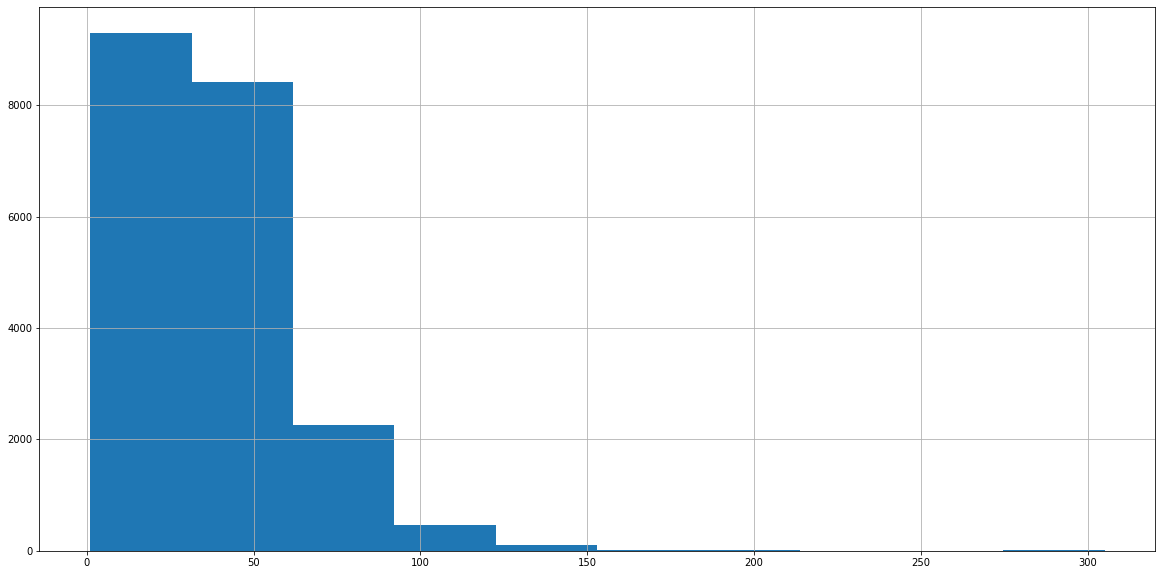

In [ ]:
description_thai_word_count.hist(figsize = (20, 10))

In [ ]:
X_text_train = description_thai_tokenize_train.to_list()
X_text_val = description_thai_tokenize_val.to_list()

### Thai2Fit - predict faculty

In [ ]:
# df

In [ ]:
# Example
from pythainlp.word_vector import sentence_vectorizer

sentence = 'อ้วนเสี้ยวเข้ายึดแคว้นกิจิ๋ว ในปี พ.ศ. 735'
example_vector = sentence_vectorizer(sentence, use_mean=True)
print(example_vector.shape)

In [ ]:
def doc2vec(text): 
    return sentence_vectorizer(text, use_mean=True)

In [ ]:
t2f_train = None

with mp.Pool(mp.cpu_count()) as p:
  t2f_train =  np.array(list(tqdm(p.imap(doc2vec, train_X_base), total = len(train_X_base)))).squeeze()
  t2f_test = np.array(list(tqdm(p.imap(doc2vec, val_X_base), total = len(val_X_base)))).squeeze()

In [ ]:
t2f_test.shape

#### Faculty

In [ ]:
Y_t2f_train = train_Y_text
Y_t2f_test = val_Y_text

In [ ]:
# print(X_t2f.shape)
# print(Y_t2f.shape)

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn import svm

# # t2f_train, t2f_test, Y_t2f_train, Y_t2f_test = train_test_split(X_t2f, Y_t2f, test_size = 0.10, random_state = 42)
# t2f_train, t2f_test, Y_t2f_train, Y_t2f_test = train_test_split(X_t2f, Y_t2f, test_size=0.1, random_state=25, stratify=Y_t2f)

In [ ]:
Y_t2f_train

In [ ]:
enc.inverse_transform(train_labels)

### Thai2Fit - predict study program

In [ ]:
# df

In [ ]:
# # Example
# from pythainlp.word_vector import sentence_vectorizer

# sentence = 'อ้วนเสี้ยวเข้ายึดแคว้นกิจิ๋ว ในปี พ.ศ. 735'
# example_vector = sentence_vectorizer(sentence, use_mean=True)
# print(example_vector.shape)

In [ ]:
# def doc2vec(text): 
#     return sentence_vectorizer(text, use_mean=True)

In [ ]:
# X_t2f = None

# with mp.Pool(mp.cpu_count()) as p:
#   X_t2f = list(tqdm(p.imap(doc2vec, df['description_thai']), total = len(df)))

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

In [ ]:
X_t2f = np.array(X_t2f).squeeze()

In [ ]:
X_t2f_nn = np.array([X_t2f[i] for i in Y_program.index])

In [ ]:
print(X_t2f_nn.shape)
print(Y_program_nn.shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm

t2f_train_program, t2f_program, Y_t2f_test_program, Y_t2f_program = train_test_split(X_t2f_nn, Y_program_nn, test_size = 0.10, random_state = 42)

### TF-IDF - study program predict

In [ ]:
df

In [ ]:
from pythainlp.corpus import thai_stopwords
stopwords = list(thai_stopwords())

In [ ]:
X_text_program = [X_text[i] for i in Y_program.index]

In [ ]:
len(X_text_program)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
tf_idf = vectorizer.fit_transform(X_text_program)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

In [ ]:
from sklearn.model_selection import train_test_split

tf_train_program, tf_test_program, Y_tf_train_program, Y_tf_test_program = train_test_split(tf_idf, Y_program_nn, test_size = 0.10, random_state = 42)

### TF-IDF - faculty predict

In [ ]:
# df

In [ ]:
from pythainlp.corpus import thai_stopwords
stopwords = list(thai_stopwords())

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
vectorizer.fit(X_text_train + X_text_val)
# vectorizer.fit(X_text_val)
tf_train = vectorizer.transform(X_text_train)
tf_test = vectorizer.transform(X_text_val)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ก', 'ข', 'ค', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ญ', 'ฏ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ส', 'ห', 'อ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', '็', '่', '้', '๊', '๋', '์', 'ํ', '\ufeff'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
Y_tf_train = train_Y_text
Y_tf_test = val_Y_text

### Count vectorizer (Bayes naives) - faculty predict

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def identity_tokenizer(text):
    return text

count_vectorizer = CountVectorizer(tokenizer=identity_tokenizer, lowercase=False, stop_words=stopwords)
count_vectorizer.fit(X_text_train + X_text_val)
# vectorizer.fit(X_text_val)
count_train = count_vectorizer.transform(X_text_train)
count_test = count_vectorizer.transform(X_text_val)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ก', 'ข', 'ค', 'ง', 'จ', 'ฉ', 'ช', 'ซ', 'ญ', 'ฏ', 'ด', 'ต', 'ถ', 'ท', 'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ภ', 'ม', 'ย', 'ร', 'ล', 'ว', 'ศ', 'ส', 'ห', 'อ', 'ะ', 'ั', 'า', 'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'เ', 'แ', 'โ', 'ใ', 'ไ', '็', '่', '้', '๊', '๋', '์', 'ํ', '\ufeff'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Keras LSTM preprocess



In [ ]:
import numpy as np

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Input
MAX_WORDS = 2500
MAX_SEQUENCE_LENGTH = description_thai_word_count.max()
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_X_base)
word_index = tokenizer.word_index
X_train = np.array(tokenizer.texts_to_sequences(train_X_base))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
X_test = np.array(tokenizer.texts_to_sequences(val_X_base))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
# X = np.array(list(map(lambda x: np.array(x), X)))

In [ ]:
# tokenizer_y = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
# tokenizer_y.fit_on_texts(Y_text)
# word_index_y = tokenizer_y.word_index
# Y = np.array(tokenizer_y.texts_to_sequences(Y_text))
# Y

In [ ]:
# len(word_index_y.keys())

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc_onehot = OneHotEncoder()
Y_train = enc_onehot.fit_transform(train_Y_text.reshape((-1, 1))).toarray()
Y_test = enc_onehot.fit_transform(val_Y_text.reshape((-1, 1))).toarray()
Y_test

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
Y_test.shape

(2288, 26)

In [ ]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
X_train

array([[  0,   0,   0, ...,   0,   9,  58],
       [  0,   0,   0, ...,   0,   0, 661],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   1,   1,   2],
       [  0,   0,   0, ...,   0,   2, 294],
       [  0,   0,   0, ...,   7,   3,  20]], dtype=int32)

In [ ]:
# # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=25, stratify=Y)


In [ ]:
X_train.shape

(20584, 305)

In [ ]:
Y_train.shape

(20584, 26)

### Keras LSTM preprocess - study program



In [ ]:
import numpy as np

In [ ]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Input
MAX_WORDS = 2500
MAX_SEQUENCE_LENGTH = description_thai_word_count.max()
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
tokenizer.fit_on_texts(X_text)
word_index = tokenizer.word_index
X = np.array(tokenizer.texts_to_sequences(X_text))

In [ ]:
# X = np.array(list(map(lambda x: np.array(x), X)))

In [ ]:
# tokenizer_y = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
# tokenizer_y.fit_on_texts(Y_text)
# word_index_y = tokenizer_y.word_index
# Y = np.array(tokenizer_y.texts_to_sequences(Y_text))
# Y

In [ ]:
# len(word_index_y.keys())

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# Y = enc.fit_transform(Y).toarray()
# Y

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# One-hot encode data
Y_program_nn = mlb.fit_transform(Y_program.values)
Y_program_nn

In [ ]:
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
X

In [ ]:
X_nn = [X[i] for i in Y_program.index]

In [ ]:
X_train, X_test, Y_train_program, Y_test_program = train_test_split(X_nn, Y_program_nn, test_size = 0.10, random_state = 42)

In [ ]:
X_train.shape

In [ ]:
Y_train.shape

## Train model

### Thai2Fit  SVM
t2f_train, t2f_test, Y_t2f_train, Y_t2f_test

In [ ]:
clf = svm.SVC()
clf.fit(t2f_train, Y_t2f_train)

SVC()

In [ ]:
Y_pred = clf.predict(t2f_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_t2f_test, Y_pred, average="macro")
acc = accuracy_score(Y_t2f_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.6638986013986014,
    "f1": 0.48960375070136486,
    "precision": 0.5695130025224023,
    "recall": 0.46782297930356587
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
  # configure the model with specific hyperparameters
  model = SVC()
  model.set_params(**params)
  # define test harness
  cv = KFold(n_splits=5, shuffle=True)
  # calculate 5-fold cross validation
  result = cross_val_score(model, t2f_train, Y_t2f_train, cv=cv, n_jobs=-1, scoring='f1_micro')
  # calculate the mean of the scores
  estimate = mean(result)
  # convert from a maximizing score to a minimizing score
  print('estimate', estimate, params)
  return 1.0 - estimate

In [ ]:
## Load checkpoint
from skopt import load


x0 = None
y0 = None
try:
    res = load('./data/checkpoint_svn_thai2fit.pkl')
    x0 = res.x_iters
    y0 = res.func_vals
except:
    print('error')

print(x0)
print(y0)

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from skopt import gp_minimize


n_calls = 50

# perform optimization
result = gp_minimize(evaluate_model, search_space, x0 = x0, y0 = y0, n_calls=n_calls, callback=BayesianCallback(total=n_calls, start=len(x0) if x0 else 0, checkpoint_path="./data/checkpoint_svn_thai2fit.pkl", compress=9))
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

### Thai 2 Fit - KNearest neighbor Predict faculty 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)

In [ ]:
neigh.fit(t2f_train, Y_t2f_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
Y_pred = neigh.predict(t2f_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_t2f_test, Y_pred, average="macro")
acc = accuracy_score(Y_t2f_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.6027097902097902,
    "f1": 0.5246294636746153,
    "precision": 0.5976747140044857,
    "recall": 0.49835314610645515
}


### TF-IDF Bayes naives

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf=MultinomialNB()
clf.fit(tf_train, Y_tf_train)

MultinomialNB()

In [ ]:
Y_pred = clf.predict(tf_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_tf_test, Y_pred, average="macro")
acc = accuracy_score(Y_tf_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.611013986013986,
    "f1": 0.3514691310323422,
    "precision": 0.5837928470194977,
    "recall": 0.3300547777276946
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Count Bayes naives

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf=MultinomialNB()
clf.fit(count_train, Y_tf_train)

MultinomialNB()

In [ ]:
Y_pred = clf.predict(count_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_tf_test, Y_pred, average="macro")
acc = accuracy_score(Y_tf_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.7172202797202797,
    "f1": 0.5540836360075948,
    "precision": 0.6441031428742109,
    "recall": 0.5360199798903124
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TF-IDF - KNearest neighbor Predict faculty 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)

In [ ]:
neigh.fit(tf_train, Y_tf_train)

KNeighborsClassifier()

In [ ]:
Y_pred = neigh.predict(tf_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_tf_test, Y_pred, average="macro")
acc = accuracy_score(Y_tf_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.7377622377622378,
    "f1": 0.6347914487410647,
    "precision": 0.6850011720386763,
    "recall": 0.6158849925166823
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TF-IDF SVM
tf_train, tf_test, Y_tf_train, Y_tf_test

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(tf_train, Y_tf_train)

SVC()

In [ ]:
Y_pred = clf.predict(tf_test)

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(Y_tf_test, Y_pred, average="macro")
acc = accuracy_score(Y_tf_test, Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.8063811188811189,
    "f1": 0.7043644139383716,
    "precision": 0.7893266232716175,
    "recall": 0.6717739140875244
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(Y_tf_test, Y_pred, target_names=target_names))

              precision    recall  f1-score   support

          02       0.00      0.00      0.00         9
          20       0.59      0.28      0.38        60
          21       0.71      0.85      0.77       245
          22       0.84      0.90      0.87       261
          23       0.70      0.79      0.74       204
          24       0.82      0.80      0.81        64
          25       0.76      0.81      0.78        84
          26       0.71      0.76      0.73        91
          27       0.81      0.84      0.82       241
          28       0.83      0.86      0.85        99
          29       0.84      0.52      0.64        50
          30       0.81      0.92      0.86       265
          31       0.94      0.87      0.91        94
          32       0.98      0.82      0.89       101
          33       0.93      0.83      0.88       102
          34       0.92      0.88      0.90        52
          35       0.96      0.62      0.76        40
          36       0.96    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from skopt.utils import use_named_args
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical

# define the space of hyperparameters to search
search_space = list()
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='C'))
search_space.append(Categorical(['linear', 'poly', 'rbf', 'sigmoid'], name='kernel'))
search_space.append(Integer(1, 5, name='degree'))
search_space.append(Real(1e-6, 100.0, 'log-uniform', name='gamma'))

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
  # configure the model with specific hyperparameters
  model = SVC()
  model.set_params(**params)
  # define test harness
  cv = KFold(n_splits=5, shuffle=True)
  # calculate 5-fold cross validation
  result = cross_val_score(model, tf_train, Y_tf_train, cv=cv, n_jobs=-1, scoring='f1_micro')
  # calculate the mean of the scores
  estimate = mean(result)
  # convert from a maximizing score to a minimizing score
  print('estimate', estimate, params)
  return 1.0 - estimate

In [ ]:
## Load checkpoint
from skopt import load


x0 = None
y0 = None
try:
    res = load('./data/checkpoint.pkl')
    x0 = res.x_iters
    y0 = res.func_vals
except:
    print('error')

print(x0)
print(y0)

[[3.3108186896717307, 'rbf', 2, 0.6711266101623925], [0.00033551814926827497, 'rbf', 2, 4.29035995889377], [0.0008919763005596203, 'poly', 1, 3.101599867657219e-05], [0.06543527889685069, 'linear', 2, 1.2302823027169885], [0.2131906334829466, 'linear', 3, 14.273101079855673], [0.141645115505999, 'sigmoid', 3, 3.467809774016928e-05], [41.72776409082915, 'linear', 2, 0.0697824196604436], [0.0032132658526691405, 'rbf', 3, 0.041289776551754406], [6.237846841431372e-05, 'poly', 2, 0.0960665325906951], [1.6913898293443755e-06, 'rbf', 2, 0.0005435147159631662], [0.0068801667004534705, 'linear', 3, 21.661155168208193], [19.62255646305339, 'linear', 5, 0.0005312342102326412], [41.5493616256875, 'rbf', 4, 0.005147140720920628], [0.9563667993994027, 'poly', 3, 4.950340299837381], [28.328238532336346, 'poly', 3, 0.45883076303255255], [0.0005240805096055802, 'sigmoid', 1, 0.5224348342549675], [0.00013033653657864322, 'poly', 1, 0.00033878168177218793], [0.004169903385691833, 'poly', 4, 0.4943200139

In [ ]:
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from skopt import gp_minimize

n_calls = 50

# perform optimization
result = gp_minimize(evaluate_model, search_space, x0 = x0, y0 = y0, n_calls=n_calls, callback=BayesianCallback(total=n_calls, start=len(x0) if x0 else 0, checkpoint_path="./data/checkpoint.pkl", compress=9))
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: %s' % (result.x))

### TF-IDF Neural network - predict faculty
tf_train, tf_test, Y_tf_train, Y_tf_test

In [ ]:
tf_train_nn = tf_train.toarray()
tf_test_nn = tf_test.toarray()
tf_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
Y_tf_train

array(['26', '37', '24', ..., '39', '26', '27'], dtype=object)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc_onehot = OneHotEncoder()
Y_tf_train_nn = enc_onehot.fit_transform(Y_tf_train.reshape((-1, 1))).toarray()
Y_tf_test_nn = enc_onehot.fit_transform(Y_tf_test.reshape((-1, 1))).toarray()
Y_tf_train_nn

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
print(Y_tf_train_nn.shape)
print(tf_train_nn.shape)

(20584, 26)
(20584, 13978)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

# import numpy as np
# tf_train_nn = np.ones((20584, 13978))
# Y_tf_train_nn = np.ones((20584, 26))

input = Input(shape=(tf_train_nn.shape[1], ))
x = Dense(512, activation="tanh", name='Hidden_1')(input)
x = Dropout(0.2)(x)
# x = Dense(512, activation="tanh", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
x = Dense(32, activation="tanh", name='Hidden_3')(x)
x = Dropout(0.1)(x)
output = Dense(Y_tf_train_nn.shape[1], activation="softmax",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

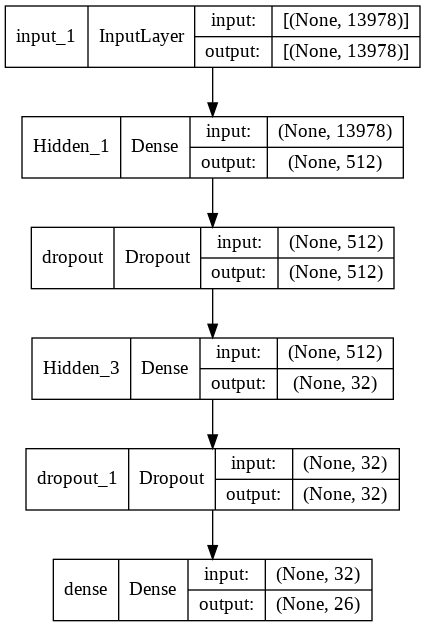

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 150
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(tf_train_nn, Y_tf_train_nn, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/150
10/10 [==============================] - 2s 68ms/step - loss: 0.6383 - accuracy: 0.0305 - val_loss: 0.5219 - val_accuracy: 0.0204
Epoch 2/150
10/10 [==============================] - 0s 43ms/step - loss: 0.4358 - accuracy: 0.0272 - val_loss: 0.3219 - val_accuracy: 0.0204
Epoch 3/150
10/10 [==============================] - 0s 45ms/step - loss: 0.2870 - accuracy: 0.0290 - val_loss: 0.2381 - val_accuracy: 0.0204
Epoch 4/150
10/10 [==============================] - 0s 43ms/step - loss: 0.2277 - accuracy: 0.0297 - val_loss: 0.2025 - val_accuracy: 0.0204
Epoch 5/150
10/10 [==============================] - 0s 46ms/step - loss: 0.1992 - accuracy: 0.0290 - val_loss: 0.1831 - val_accuracy: 0.0204
Epoch 6/150
10/10 [==============================] - 0s 44ms/step - loss: 0.1825 - accuracy: 0.0297 - val_loss: 0.1715 - val_accuracy: 0.0204
Epoch 7/150
10/10 [==============================] - 0s 45ms/step - loss: 0.1728 - accuracy: 0.0364 - val_loss: 0.1643 - val_accuracy: 0.0204
Epoch 

In [ ]:
y_pred = model.predict(tf_test_nn)

In [ ]:
Y_tf_test_nn

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
nn_faculty_labels = list(map(np.argmax, Y_tf_test_nn))
nn_faculty_pred = list(map(np.argmax, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(nn_faculty_labels, nn_faculty_pred, average="macro")
acc = accuracy_score(nn_faculty_labels, nn_faculty_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.7561188811188811,
    "f1": 0.5997095697806403,
    "precision": 0.6998982125604563,
    "recall": 0.5800505895465361
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### TF-IDF Neural network - predict study program
tf_train_program, tf_test_program, Y_tf_train_program, Y_tf_test_program

In [ ]:
tf_train_program_nn = tf_train_program.toarray()

In [ ]:
print(tf_train_program_nn.shape)
print(Y_tf_train_program.shape)

(10394, 11069)
(10394, 483)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(tf_train_program.shape[1], ))
x = Dense(1024, activation="relu", name='Hidden_1')(input)
x = Dropout(0.4)(x)
# x = Dense(512, activation="relu", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation="relu", name='Hidden_3')(x)
# x = Dropout(0.2)(x)
output = Dense(Y_tf_train_program.shape[1], activation="sigmoid",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

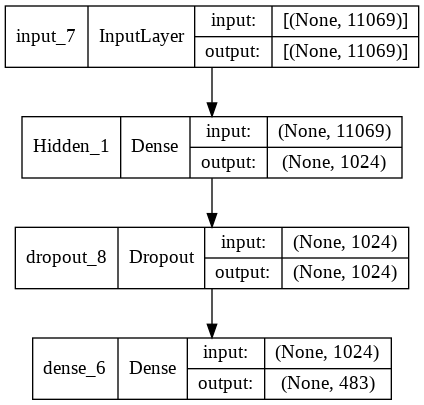

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(tf_train_program_nn, Y_tf_train_program, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
5/5 [==============================] - 1s 163ms/step - loss: 0.5015 - accuracy: 0.0012 - val_loss: 0.0488 - val_accuracy: 9.6154e-04
Epoch 2/10
5/5 [==============================] - 0s 95ms/step - loss: 0.0316 - accuracy: 0.0045 - val_loss: 0.0379 - val_accuracy: 0.0260
Epoch 3/10
5/5 [==============================] - 0s 92ms/step - loss: 0.0469 - accuracy: 0.0192 - val_loss: 0.0552 - val_accuracy: 0.0260
Epoch 4/10
5/5 [==============================] - 0s 86ms/step - loss: 0.0597 - accuracy: 0.0195 - val_loss: 0.0600 - val_accuracy: 0.0260
Epoch 5/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0612 - accuracy: 0.0195 - val_loss: 0.0565 - val_accuracy: 0.0183
Epoch 6/10
5/5 [==============================] - 0s 87ms/step - loss: 0.0556 - accuracy: 0.0144 - val_loss: 0.0495 - val_accuracy: 0.0077
Epoch 7/10
5/5 [==============================] - 0s 92ms/step - loss: 0.0472 - accuracy: 0.0067 - val_loss: 0.0416 - val_accuracy: 0.0202
Epoch 8/10
5/5 [======

### Thai2Fit Neural network - predict study program
t2f_train_program, t2f_program, Y_t2f_test_program, Y_t2f_program

In [ ]:
# tf_train_program_nn = tf_train_program.toarray()

In [ ]:
print(t2f_train_program.shape)
print(Y_t2f_test_program.shape)

(10394, 300)
(10394, 483)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

input = Input(shape=(t2f_train_program.shape[1], ))
# x = Dense(512, activation="relu", name='Hidden_1')(input)
# x = Dropout(0.1)(x)
# x = Dense(512, activation="relu", name='Hidden_2')(x)
# x = Dropout(0.2)(x)
# x = Dense(512, activation="relu", name='Hidden_3')(x)
x = Dropout(0.2)(input)
output = Dense(Y_t2f_test_program.shape[1], activation="sigmoid",)(x)

model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['accuracy'])

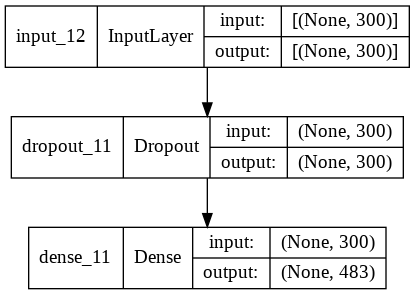

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 2048
# batch_size = tf_train_nn.shape[0]

model.fit(t2f_train_program, Y_t2f_test_program, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
5/5 [==============================] - 0s 45ms/step - loss: 0.0107 - accuracy: 0.4845 - val_loss: 0.0145 - val_accuracy: 0.2788
Epoch 2/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4833 - val_loss: 0.0145 - val_accuracy: 0.2798
Epoch 3/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4886 - val_loss: 0.0145 - val_accuracy: 0.2798
Epoch 4/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0106 - accuracy: 0.4917 - val_loss: 0.0145 - val_accuracy: 0.2788
Epoch 5/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0106 - accuracy: 0.4897 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4912 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 7/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0107 - accuracy: 0.4882 - val_loss: 0.0145 - val_accuracy: 0.2808
Epoch 8/100
5/5 [===

### LSTM - predict study program
X_train, X_test, Y_train_program, Y_test_program

In [ ]:
X_train = np.array(X_train)

In [ ]:
print(X_train.shape)
print(Y_train_program.shape)

(10394, 305)
(10394, 483)


In [ ]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import regularizers

# input = Input(shape=(X_train.shape[1], ))
# x = Dense(1024, activation="relu", name='Hidden_1')(input)
# x = Dropout(0.4)(x)
# # x = Dense(512, activation="relu", name='Hidden_2')(x)
# # x = Dropout(0.2)(x)
# # x = Dense(512, activation="relu", name='Hidden_3')(x)
# # x = Dropout(0.2)(x)
# output = Dense(Y_test_program.shape[1], activation="sigmoid",)(x)

# model = tf.keras.Model(inputs=input, outputs=output, name="TF-IDF_NN")


model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_test_program.shape[1], activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

# epochs = 5
# batch_size = 2048

# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

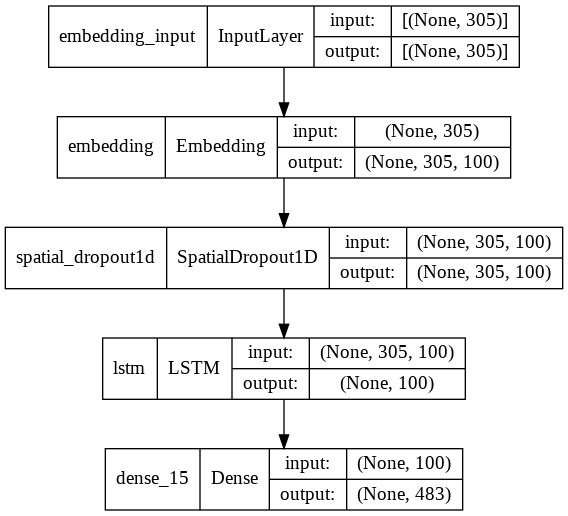

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 100
batch_size = 512
# batch_size = tf_train_nn.shape[0]

model.fit(X_train, Y_train_program, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/100
19/19 [==============================] - 52s 3s/step - loss: 0.0590 - accuracy: 0.0025 - val_loss: 0.0315 - val_accuracy: 0.0019
Epoch 2/100
19/19 [==============================] - 52s 3s/step - loss: 0.0284 - accuracy: 0.0025 - val_loss: 0.0247 - val_accuracy: 0.0019
Epoch 3/100
19/19 [==============================] - 51s 3s/step - loss: 0.0248 - accuracy: 0.0025 - val_loss: 0.0231 - val_accuracy: 0.0019
Epoch 4/100
19/19 [==============================] - 52s 3s/step - loss: 0.0236 - accuracy: 0.0159 - val_loss: 0.0223 - val_accuracy: 0.0260
Epoch 5/100
19/19 [==============================] - 52s 3s/step - loss: 0.0229 - accuracy: 0.0195 - val_loss: 0.0218 - val_accuracy: 0.0260
Epoch 6/100
19/19 [==============================] - 52s 3s/step - loss: 0.0225 - accuracy: 0.0195 - val_loss: 0.0215 - val_accuracy: 0.0260
Epoch 7/100
19/19 [==============================] - 52s 3s/step - loss: 0.0221 - accuracy: 0.0195 - val_loss: 0.0212 - val_accuracy: 0.0260
Epoch 8/100
1

### LSTM
X_train, X_test, Y_train, Y_test

In [ ]:
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 100
# batch_size = 2048
batch_size = 512

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/100
37/37 [==============================] - 42s 1s/step - loss: 1.5509 - accuracy: 0.5062 - val_loss: 2.8766 - val_accuracy: 0.3409
Epoch 2/100
37/37 [==============================] - 41s 1s/step - loss: 1.5497 - accuracy: 0.5064 - val_loss: 2.8756 - val_accuracy: 0.3414
Epoch 3/100
37/37 [==============================] - 41s 1s/step - loss: 1.5493 - accuracy: 0.5066 - val_loss: 2.8768 - val_accuracy: 0.3419
Epoch 4/100
37/37 [==============================] - 42s 1s/step - loss: 1.5465 - accuracy: 0.5075 - val_loss: 2.8813 - val_accuracy: 0.3405
Epoch 5/100
37/37 [==============================] - 41s 1s/step - loss: 1.5429 - accuracy: 0.5073 - val_loss: 2.8853 - val_accuracy: 0.3409
Epoch 6/100
37/37 [==============================] - 42s 1s/step - loss: 1.5462 - accuracy: 0.5069 - val_loss: 2.8866 - val_accuracy: 0.3395
Epoch 7/100
37/37 [==============================] - 41s 1s/step - loss: 1.5420 - accuracy: 0.5099 - val_loss: 2.8911 - val_accuracy: 0.3400
Epoch 8/100
3

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, Y_test)

72/72 [==============================] - 6s 82ms/step - loss: 2.8235 - accuracy: 0.3300


[2.8235437870025635, 0.3299825191497803]

In [ ]:
for x in X_test[0]:
  if x != 0:
    key =  list(word_index.keys())[list(word_index.values()).index(x)]
    print(key, end='')

ได้แก่ฮาร์ดแวร์การจัดการข้อมูลได้แก่การออกแบบ

In [ ]:
word_index

{'ๆ': 1,
 'ได้แก่': 2,
 'หลักการ': 3,
 'และ': 4,
 'แนวคิด': 5,
 'สังคม': 6,
 'ทฤษฎี': 7,
 'การวินิจฉัย': 8,
 'เช่น': 9,
 'เศรษฐกิจ': 10,
 'การตรวจร่างกาย': 11,
 'การวิเคราะห์': 12,
 'ความหมาย': 13,
 '2': 14,
 'วัฒนธรรม': 15,
 'เทคนิค': 16,
 'การเมือง': 17,
 '1': 18,
 'โครงสร้าง': 19,
 'รูปแบบ': 20,
 'วินิจฉัย': 21,
 'วิธีการ': 22,
 'การซักประวัติ': 23,
 'การสัมภาษณ์ประวัติ': 24,
 'ที่เกี่ยวข้อง': 25,
 'สาเหตุ': 26,
 'วิเคราะห์': 27,
 '3': 28,
 'การ': 29,
 'การวางแผน': 30,
 'การตรวจทางห้องปฏิบัติการ': 31,
 'การวางแผนการรักษา': 32,
 'พยาธิกำเนิด': 33,
 'การออกแบบ': 34,
 'พูด': 35,
 'อ่าน': 36,
 'ข้อบ่งชี้': 37,
 'การศึกษาในต่างประเทศตามที่หลักสูตรกำหนด': 38,
 'การรักษา': 39,
 'ปรัชญา': 40,
 'พยาธิสรีรวิทยา': 41,
 'กรณีศึกษา': 42,
 'การอ่าน': 43,
 'การตรวจ': 44,
 'การวิเคราะห์ข้อมูล': 45,
 'การนำเสนอ': 46,
 'อาการ': 47,
 'ตรวจร่างกาย': 48,
 'กระบวนการ': 49,
 'ลักษณะ': 50,
 'การแปลผล': 51,
 'เนื้อหา': 52,
 'มิติ': 53,
 'หรือ': 54,
 'บทบาท': 55,
 'พยาธิสภาพ': 56,
 'พัฒนาการ': 57,
 'เป็นต้น'

In [ ]:
model.predict(X_test[0].reshape(1, X_test.shape[1]))

array([[2.2441312e-05, 1.2329794e-03, 8.0365670e-04, 1.5156225e-05,
        1.0246441e-04, 1.9864343e-01, 7.5882381e-01, 2.1674315e-02,
        3.5112442e-03, 2.9225493e-04, 2.1153326e-06, 3.2554877e-03,
        2.2920849e-06, 6.2558259e-04, 5.3564413e-03, 3.4621786e-04,
        5.0978451e-03, 6.9489482e-07, 1.9070803e-06, 2.4834251e-05,
        1.5071752e-04, 6.4062090e-07, 8.1080098e-06, 2.7506410e-06,
        2.6723458e-06, 5.8044602e-08]], dtype=float32)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
lstm_faculty_labels = list(map(np.argmax, Y_test))
lstm_faculty_pred = list(map(np.argmax, y_pred))

precision, recall, f1, _ = precision_recall_fscore_support(lstm_faculty_labels, lstm_faculty_pred, average="macro")
acc = accuracy_score(lstm_faculty_labels, lstm_faculty_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.3299825174825175,
    "f1": 0.28104876014072944,
    "precision": 0.3891275176557481,
    "recall": 0.24453356999214734
}


In [ ]:
# from keras import backend as K
# K.clear_session()

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

### Wangchan berta

#### Train model

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)

    # classification_report_result = classification_report(labels, preds, target_names=target_names)

    # print(classification_report_result)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        # 'report': classification_report_result
    }

In [ ]:
training_args = TrainingArguments(
    output_dir='./faculty_classification',          # output directory
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./faculty_classification_logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='epoch'
)

In [ ]:
revision = None
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=label_number,
    label2id=label2id,
    id2label=id2label,
    revision=revision
)

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,        # evaluation dataset
    compute_metrics=compute_metrics,
)

In [ ]:
# pip install torch==1.5.0

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 20584
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 12870


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


Saving model checkpoint to ./faculty_classification/checkpoint-500
Configuration saved in ./faculty_classification/checkpoint-500/config.json
Model weights saved in ./faculty_classification/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./faculty_classification/checkpoint-1000
Configuration saved in ./faculty_classification/checkpoint-1000/config.json


In [ ]:
# torch.cuda.empty_cache()
# import gc
# del trainer
# gc.collect()

NameError: ignored

In [ ]:
for name, param in model.named_parameters():
  print('check', name, param.requires_grad)

check roberta.embeddings.word_embeddings.weight True
check roberta.embeddings.position_embeddings.weight True
check roberta.embeddings.token_type_embeddings.weight True
check roberta.embeddings.LayerNorm.weight True
check roberta.embeddings.LayerNorm.bias True
check roberta.encoder.layer.0.attention.self.query.weight True
check roberta.encoder.layer.0.attention.self.query.bias True
check roberta.encoder.layer.0.attention.self.key.weight True
check roberta.encoder.layer.0.attention.self.key.bias True
check roberta.encoder.layer.0.attention.self.value.weight True
check roberta.encoder.layer.0.attention.self.value.bias True
check roberta.encoder.layer.0.attention.output.dense.weight True
check roberta.encoder.layer.0.attention.output.dense.bias True
check roberta.encoder.layer.0.attention.output.LayerNorm.weight True
check roberta.encoder.layer.0.attention.output.LayerNorm.bias True
check roberta.encoder.layer.0.intermediate.dense.weight True
check roberta.encoder.layer.0.intermediate.den

In [ ]:
result_eval = trainer.evaluate()

In [ ]:
import json

print(json.dumps(result_eval, indent=4))

{
    "eval_loss": 0.9646991491317749,
    "eval_accuracy": 0.8518356643356644,
    "eval_f1": 0.7791171681418476,
    "eval_precision": 0.7787616402930839,
    "eval_recall": 0.7919981879519274
}


In [ ]:
# !curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
# !sudo apt-get install git-lfs
# !git lfs install

In [ ]:
# transformers-cli login

In [ ]:
# model_check.push_to_hub("new5558/wangchan-course", repo_url="https://huggingface.co/new5558/wangchan-course")

#### Analyse WangChan result

In [ ]:
model_check = AutoModelForSequenceClassification.from_pretrained("new5558/wangchan-course")

In [ ]:
text = process_transformers("มูลเหตุ อิทธิพลต่างๆ และแนวความคิดในการสร้างสรรค์งานศิลปะและสถาปัตยกรรม การวิเคราะห์และวิจารณ์ผลงานศิลปะและสถาปัตยกรรม ประวัติศาสตร์ศิลปะและและสถาปัตยกรรมตะวันตกโดยสังเขป ตั้งแต่สมัยก่อนประวัติศาสตร์จนถึงคริสต์ศตวรรษที่ 20")

device = "cuda"

_inputs = tokenizer(text, return_tensors="pt").to(device)
# _inputs = tokenizer(text, return_tensors="pt")

outputs = model_check(**_inputs)

outputs

(tensor([[ 1.8677, -0.3342, -1.3128,  1.0767, -1.0225, -0.3569, 10.3153, -0.2828,
           2.4082, -0.4426,  0.0517, -1.7291, -1.9308, -1.3181, -1.0596, -0.8833,
           0.2908,  0.2941, -1.9218,  0.0291,  0.9976, -0.2248, -0.9278, -1.7475,
          -2.3012, -1.6214]], device='cuda:0', grad_fn=<AddmmBackward>),)

In [ ]:
from torch.nn.functional import softmax
prediction_result = softmax(outputs[0], dim=1).cpu().data.numpy().round(2)
np.argmax(prediction_result)

6

In [ ]:
softmax(outputs[0], dim=1).cpu().data.numpy().round(3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.999, 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]],
      dtype=float32)

In [ ]:
enc.inverse_transform([[6]])

array([['25']], dtype=object)

In [ ]:
from transformers import TextClassificationPipeline

pipeline = TextClassificationPipeline(model = model_check, tokenizer = tokenizer, device=0)

In [ ]:
import transformers
import shap

# explain the model on two sample inputs
explainer = shap.Explainer(pipeline) 
shap_values = explainer([process_transformers("มูลเหตุ อิทธิพลต่างๆ และแนวความคิดในการสร้างสรรค์งานศิลปะและสถาปัตยกรรม การวิเคราะห์และวิจารณ์ผลงานศิลปะและสถาปัตยกรรม ประวัติศาสตร์ศิลปะและและสถาปัตยกรรมตะวันตกโดยสังเขป ตั้งแต่สมัยก่อนประวัติศาสตร์จนถึงคริสต์ศตวรรษที่ 20")])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, int(enc.transform([['25']])[0][0])])

In [ ]:
shap.plots.text(shap_values[0, :, int(enc.transform([['22']])[0][0])])

In [ ]:
shap.plots.text(shap_values[0, :, int(enc.transform([['35']])[0][0])])

In [ ]:
index =  1020#@param {type:"integer"}

text = val_texts[index]
label = val_labels[index]
print(f"text: {text}")
print(f"label: {label}")
print(f"prediction: {pipeline(text)[0]}")
print(f"label inversed: {enc.inverse_transform([label])}")

# explain the model on two sample inputs
explainer = shap.Explainer(pipeline) 
shap_values = explainer([process_transformers(text)])

# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, int(label)])

text: การศึกษาวิเคราะห์ในหัวข้อเฉพาะเรื่องด้านภาษา<_>ดนตรี<_>ศิลปะ<_>ภาพยนตร์<_>ประวัติศาสตร์<_>หรือปรัชญาของอิตาลี
label: [3.]
prediction: {'label': 'LABEL_3', 'score': 0.9998988509178162}
label inversed: [['22']]


## Use trained model to embed text

In [ ]:
text = "มูลเหตุ อิทธิพลต่างๆ และแนวความคิดในการสร้างสรรค์งานศิลปะและสถาปัตยกรรม การวิเคราะห์และวิจารณ์ผลงานศิลปะและสถาปัตยกรรม ประวัติศาสตร์ศิลปะและและสถาปัตยกรรมตะวันตกโดยสังเขป ตั้งแต่สมัยก่อนประวัติศาสตร์จนถึงคริสต์ศตวรรษที่ 20"

In [ ]:
def extract_last_k(input_text, feature_extractor, last_k=4):
    hidden_states = feature_extractor(input_text)[0]
    last_k_layers = [hidden_states[i] for i in [-i for i in range(1,last_k+1)]]
    cat_hidden_states = sum(last_k_layers, [])
    return np.array(cat_hidden_states)

In [ ]:
# from transformers import FeatureExtractionPipeline
from transformers import pipeline

feature_pipeline = pipeline(task='feature-extraction',
         tokenizer=tokenizer,
         model ="new5558/wangchan-course",
         device = 0,
         revision = 'main')
# feature_pipeline = FeatureExtractionPipeline(model = "new5558/wangchan-course", tokenizer = tokenizer, device=0)

Some weights of CamembertModel were not initialized from the model checkpoint at new5558/wangchan-course and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of CamembertModel were not initialized from the model checkpoint at new5558/wangchan-course and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
feature = feature_pipeline(process_transformers(text))
np.array(feature).shape

(1, 51, 768)

In [ ]:
final_feature = extract_last_k(process_transformers(text), feature_pipeline)

In [ ]:
final_feature.shape

(3072,)

In [ ]:
features_train = []

for textin in tqdm(train_texts):
  features_train.append(extract_last_k(process_transformers(text), feature_pipeline))

  0%|          | 0/20584 [00:00<?, ?it/s]

In [ ]:
features_test = []

for textin in tqdm(val_texts):
  features_test.append(extract_last_k(process_transformers(text), feature_pipeline))

  0%|          | 0/2288 [00:00<?, ?it/s]

In [ ]:
# features_train_df = pd.DataFrame(features_train)
# features_test_df = pd.DataFrame(features_test)

In [ ]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# define data
features_train_array = asarray(features_train)
features_test_array = asarray(features_test)
# save to npy file
savez_compressed('./data/features_train_array.npz', features_train_array)
savez_compressed('./data/features_test_array.npz', features_test_array)

In [ ]:
# # load numpy array from npz file
# from numpy import load
# # load dict of arrays
# dict_data = load('data.npz')
# # extract the first array
# data = dict_data['arr_0']
# # print the array
# print(data)

In [ ]:
features_train_array.shape

(20584, 3072)

In [ ]:
train_labels.shape

In [ ]:
from sklearn import svm

clf = svm.SVC(verbose=True)
clf.fit(features_train_array, train_labels.flatten())

[LibSVM]

Process ForkPoolWorker-28:
Process ForkPoolWorker-25:
Process ForkPoolWorker-24:
Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-22:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessin

In [ ]:
Y_pred = clf.predict(features_test_df)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels.flatten(), Y_pred, average="macro")
acc = accuracy_score(val_labels.flatten(), Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(features_train_df, train_labels.flatten())

KNeighborsClassifier()

In [ ]:
Y_pred = neigh.predict(features_test_df)
precision, recall, f1, _ = precision_recall_fscore_support(val_labels.flatten(), Y_pred, average="macro")
acc = accuracy_score(val_labels.flatten(), Y_pred)

print(json.dumps({
    'accuracy': acc,
    'f1': f1,
    'precision': precision,
    'recall': recall
}, indent=4))

{
    "accuracy": 0.03977272727272727,
    "f1": 0.0029424127784783522,
    "precision": 0.0015297202797202797,
    "recall": 0.038461538461538464
}


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
